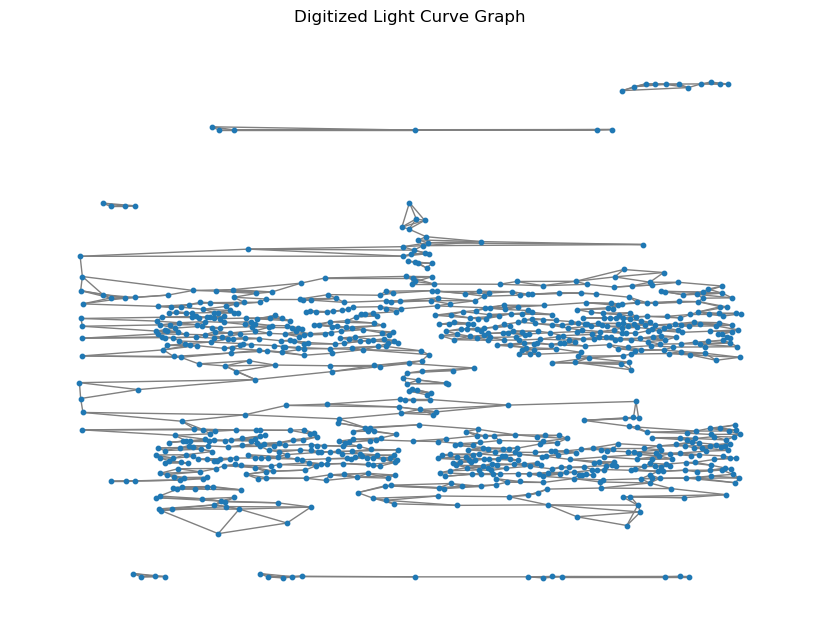

Softmax Probabilities:
 [[0.6260947  0.37390533]
 [0.6168541  0.383146  ]
 [0.59895194 0.40104803]
 [0.59190136 0.4080987 ]]
Predictions: [0 0 0 0]
True Labels: [0 1 0 1]
Epoch 1, Train Loss: 2.1013, Val Acc: 0.50
→ Predictions: [0, 0, 0, 0]
→ Ground Truth: [0, 1, 0, 1]
Softmax Probabilities:
 [[0.61145926 0.38854077]
 [0.60278606 0.3972139 ]
 [0.58672565 0.41327432]
 [0.5800381  0.4199619 ]]
Predictions: [0 0 0 0]
True Labels: [0 1 0 1]
Epoch 2, Train Loss: 2.0803, Val Acc: 0.50
→ Predictions: [0, 0, 0, 0]
→ Ground Truth: [0, 1, 0, 1]
Softmax Probabilities:
 [[0.5965227  0.4034773 ]
 [0.5883257  0.41167426]
 [0.57437354 0.42562643]
 [0.5678934  0.43210664]]
Predictions: [0 0 0 0]
True Labels: [0 1 0 1]
Epoch 3, Train Loss: 2.0652, Val Acc: 0.50
→ Predictions: [0, 0, 0, 0]
→ Ground Truth: [0, 1, 0, 1]
Softmax Probabilities:
 [[0.59282684 0.40717313]
 [0.58328307 0.41671693]
 [0.57175773 0.4282423 ]
 [0.56357735 0.43642265]]
Predictions: [0 0 0 0]
True Labels: [0 1 0 1]
Epoch 4, Train L

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, measure, morphology, util
import pandas as pd
from sklearn.neighbors import kneighbors_graph
import networkx as nx
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from glob import glob
import os  # <-- Needed for os.path.join
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

def build_graph(light_curve_file, k=3):
    img = io.imread(light_curve_file)

    # Convert RGBA or RGB to grayscale
    gray = color.rgb2gray(img[:, :, :3])  # Ensure 3 channels

    # Invert colors to make white background black
    gray_inv = util.invert(gray)

    # Otsu threshold
    thresh = filters.threshold_otsu(gray_inv)
    binary = gray_inv > thresh

    # Remove small noise
    cleaned = morphology.remove_small_objects(binary, min_size=10)

    # Label connected components
    labels = measure.label(cleaned)
    regions = measure.regionprops(labels)

    # Get centroid coordinates of features
    coords = np.array([r.centroid for r in regions])
    if coords.shape[0] == 0:
        raise ValueError(f"No data points detected in image {light_curve_file}")

    # Flip y-axis so it's increasing upward
    coords[:, 0] = img.shape[0] - coords[:, 0]

    # Define axis ranges manually (assumes fixed scale for all images)
    x_min, x_max = -1.25, 1.25
    y_min, y_max = -17.5, 2.5
    px_height, px_width = img.shape[0], img.shape[1]

    x_scaled = x_min + (coords[:, 1] / px_width) * (x_max - x_min)
    y_scaled = y_min + (coords[:, 0] / px_height) * (y_max - y_min)

    X = np.vstack((x_scaled, y_scaled)).T  # Shape (N, 2)

    # Build k-NN graph
    A = kneighbors_graph(X, n_neighbors=k, mode='connectivity', include_self=False)
    G = nx.from_scipy_sparse_array(A)

    for i, feat in enumerate(X):
        G.nodes[i]['x'] = torch.tensor(feat, dtype=torch.float)

    data = from_networkx(G)
    return data

def is_confirmed_exoplanet(filepath):
    folder = os.path.basename(os.path.dirname(filepath)).lower()
    return folder == "confirmed"

#Generating Training Data: --------------------------------------------------

# Adjust these paths to where your data is stored
confirmed_dir = r"C:\Users\bwlam\Downloads\SRP 2025 - Light Curve Datasets\Confirmed"
unconfirmed_dir = r"C:\Users\bwlam\Downloads\SRP 2025 - Light Curve Datasets\Unconfirmed"

# Load all PNGs
all_files = glob(os.path.join(confirmed_dir, "*.png")) + glob(os.path.join(unconfirmed_dir, "*.png"))

graphs = []

for file in all_files:
    try:
        data = build_graph(file)
        data.y = torch.tensor([1 if is_confirmed_exoplanet(file) else 0], dtype = torch.long)
        graphs.append(data)
    except Exception as e:
        print(f"Failed to process {file}: {e}")

# Load and build one graph from a PNG (The following code is a check- it can be removed)
file = r"C:\Users\bwlam\Downloads\SRP 2025 - Light Curve Datasets\Confirmed\TOI-109.01.png"  # Replace with your actual path
graph_data = build_graph(file)

# Extract node features (positions)
pos = graph_data.x.numpy()

# Create NetworkX version of the graph for plotting
G = nx.Graph()
for i, (x, y) in enumerate(pos):
    G.add_node(i, pos=(x, y))

edge_index = graph_data.edge_index.numpy().T
for src, dst in edge_index:
    G.add_edge(src, dst)

# Plot
plt.figure(figsize=(8, 6))
nx.draw(
    G,
    pos=nx.get_node_attributes(G, 'pos'),
    node_size=10,
    edge_color='gray',
    with_labels=False
)
plt.title("Digitized Light Curve Graph")
plt.xlabel("Phase")
plt.ylabel("Relative Flux")
plt.gca().invert_yaxis()
plt.show()

#Saving and Entering into GNN Pipeline, TRAINING: -------------------------------------------------------

# Save list of Data objects to disk
torch.save(graphs, "processed_lightcurve_graphs.pt")

# --- Calculate class weights for weighted loss --> LOSS FUNCTION IMPLEMENTATION (Cross-Entropy Loss)
# --- Balanced and normalized class weights
labels = [data.y.item() for data in graphs]
class_counts = np.bincount(labels)
inv_freq = 1. / class_counts
norm_weights = inv_freq / inv_freq.sum()
class_weights_tensor = torch.tensor(norm_weights, dtype=torch.float32).to(device)

# --- Train/val split; Now modified for the smaller dataset (as of 6/10/25)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, val_idx in sss.split(graphs, labels):
    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]

train_loader = DataLoader(train_graphs, batch_size=4, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=4, shuffle=False)

# --- Simplified model
class GraphClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GraphClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.fc(x)

model = GraphClassifier(input_dim=2, hidden_dim=32, num_classes=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# --- Training loop with per-epoch debug
best_val_acc = 0
best_model_state = None

for epoch in range(20):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_preds = []
    val_labels = []
    y_pred = []
    y_true = []

    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            probs = F.softmax(out, dim=1).cpu().numpy()
            print("Softmax Probabilities:\n", probs)
            preds = out.argmax(dim=1).cpu().numpy()
            print("Predictions:", preds)
            print("True Labels:", batch.y.cpu().numpy())

            pred = out.argmax(dim=1)
            y_pred.extend(pred.cpu().numpy())
            y_true.extend(batch.y.cpu().numpy())
            
            val_preds.extend(pred.cpu().numpy())
            val_labels.extend(batch.y.cpu().numpy())
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)

    val_acc = correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Acc: {val_acc:.2f}")
    print("→ Predictions:", val_preds)
    print("→ Ground Truth:", val_labels)

# Save best model
torch.save(best_model_state, "best_gnn_model.pt")
print(f"Best Validation Accuracy: {best_val_acc:.2f}")

# Class Distribution Report
print("Train class distribution:", Counter([g.y.item() for g in train_graphs]))
print("Val class distribution:", Counter([g.y.item() for g in val_graphs]))

# Final performance report
from sklearn.metrics import classification_report, accuracy_score

model.load_state_dict(best_model_state)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

print(classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    target_names=["Unconfirmed", "Confirmed"],
    zero_division=1
))
print("Final Validation Accuracy:", accuracy_score(all_labels, all_preds))


#Output Confusion Matrix:
def evaluate_model(model, val_graphs):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for graph in val_graphs:
            out = model(graph.x, graph.edge_index, graph.batch)
            pred = out.argmax(dim=1)
            y_pred.extend(pred.cpu().numpy())
            y_true.extend(graph.y.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

    # Plotting Confusion Matrix (Commented Out at the moment to Make output more concise)
    #plt.figure(figsize=(5, 4))
    #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unconfirmed', 'Confirmed'], yticklabels=['Unconfirmed', 'Confirmed'])
    #plt.xlabel('Predicted')
    #plt.ylabel('True')
    #plt.title('Confusion Matrix')
    #plt.show()

evaluate_model(model, val_graphs)

# Function to predict a new light curve
def predict_light_curve(file_path):
    try:
        graph = build_graph(file_path)
    except Exception as e:
        print(f"Failed to build graph: {e}")
        return None

    graph = graph.to(device)
    with torch.no_grad():
        out = model(graph.x, graph.edge_index, torch.zeros(graph.num_nodes, dtype=torch.long, device=device))
        pred = out.argmax(dim=1).item()
        label = "Confirmed" if pred == 1 else "Unconfirmed"
        return label


# Test it on a new image
test_file = r"C:\Users\bwlam\Downloads\SRP 2025 - Light Curve Datasets\Test\TOI-1254.01.png"  # Replace this path
prediction = predict_light_curve(test_file)

print(f"Prediction for {os.path.basename(test_file)}: {prediction}")

print("Label counts in all graphs:", Counter([data.y.item() for data in graphs]))

print("Class counts:", class_counts)
print("Class weights:", class_weights_tensor)

print("Model output logits:", out.cpu().numpy())